<a href="https://colab.research.google.com/github/pmakaria/pub/blob/master/TimeSeriesAnalysis/Python/Copy_of_TimeSeriesAnalysis_WeatherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis - Weather data

[Petros Makariadis](https://www.linkedin.com/in/pmakariadis/)

This is a time series analysis on weather data and more specifically on the average temperature. Original data set consists of data from 01/01/2012 to 31/05/2020. 
The level of the data set detail is the daily average temperature.

### References
Data Science Dojo<br>
https://blog.datasciencedojo.com/time-series-python-tutorials/?hss_channel=tw-1318985240<br>
<br>
ARIMA Model Python Example — Time Series Forecasting<br>
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7<br>
<br>
Auto correlation, partial correlation<br>
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/<br>
<br>
Achieving Stationarity With Time Series Data<br>
https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0<br>

11 Classical Time Series Forecasting Methods in Python (Cheat Sheet)<br>
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/<br>
<br>
Time series analysis and weather forecast in python
<br>https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71

In [ ]:
#@title import libraries
#Import needed libraries
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
import statsmodels.api as sm


If a package is missing, you can install it by giving the following command: <i>!conda install -c conda-forge packageName --yes</i>

In [ ]:
!conda install -c conda-forge statsmodels --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    pandas-1.0.5               |   py36h830a2c2_0        10.1 MB  conda-forge
    patsy-0.5.1                |             py_0         187 KB  conda-forge
    scipy-1.5.0                |   py36h2d22cac_0        18.6 MB  conda-forge
    statsmodels-0.11.1         |   py36h8c4c3a4_2         9.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        39.0 MB

The following NEW packages will be INSTALLED:

  pandas             conda-forge/linux-64::pandas-1.0.5-py

## Load Weather Dataset
Keep only needed columns and add an index.<br>
Remove empty rows

In [ ]:
#@title data set loading
#select the columns to load
col_list = ["full_day", "avg_temp"]
# create data frame
dionisos_weather_df = pd.read_csv("data/samples/mine/dionisos_weather_data.csv", usecols=col_list, parse_dates=['full_day'], sep=',',
                                  decimal='.', infer_datetime_format=True)
dionisos_weather_df.set_index("full_day", inplace=True)
# remove empty rows
dionisos_weather_df = dionisos_weather_df.dropna()

Quickly get a data description

In [ ]:
dionisos_weather_df.describe()

,avg_temp
count,3073.000000
mean,15.427335
std,7.067635
min,-3.800000
25%,10.000000
50%,15.100000
75%,21.600000
max,33.900000


At this point we will resample our data set on monthly average level.<br>
So from 3073 records, we will go down to 101 that will indicate the monthly average temperature from 2012-01 to 2020-05.
On that level, we will do our analysis and try to forecast the average monthly temperature for the next 30 months.


In [ ]:
#resample on Month Start level
dionisos_weather_df = dionisos_weather_df.resample('MS').mean()
dionisos_weather_df.describe()

,avg_temp
count,101.000000
mean,15.395578
std,6.450070
min,4.183871
25%,9.560714
50%,15.087097
75%,21.553333
max,26.738710


## Plot our dataset
It is a good idea to plot the data, in order to get an idea how our sample looks like

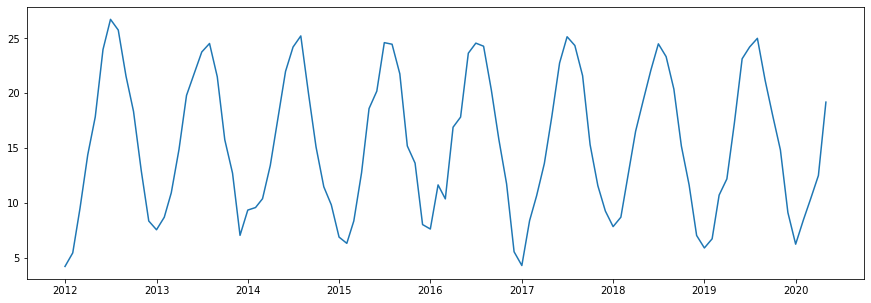

In [ ]:
#@title plot dataset
#plot original data
pyplot.figure(figsize=(15,5))
pyplot.plot(dionisos_weather_df.avg_temp)
pyplot.show()

The seasonality trends are obvious. Beginning and end of the year, it is the winter time (the area where the data set is derived is in the northern hemishpere) and the average temperatures are low, while in the middle of the year the average temperature rises due to summer.

# Checking stationarity.
Even though the data looks stationary (mean, variance and autocorrelation structure do not change over time), we will make some basic checks to validate it.

## Check #1: <br>
Rolling Statistics: Plot the rolling mean and rolling standard deviation. 
The time series is stationary if they remain constant with time (with the naked eye look to see if the lines re straight and parallel to the x-axis).


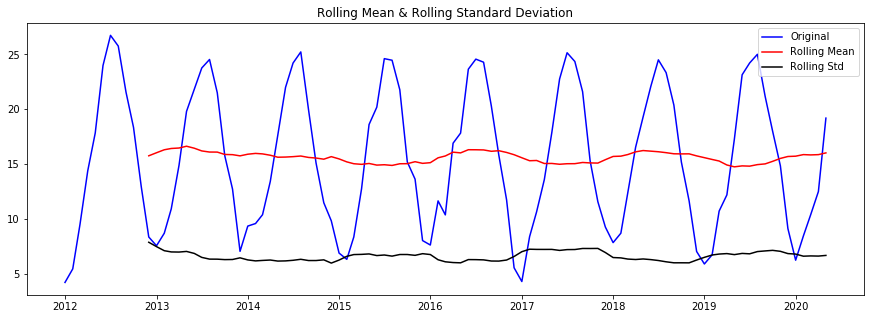

In [ ]:
#@title rolling mean and rolling stdev
rolling_mean = dionisos_weather_df.rolling(window = 12).mean().dropna()
rolling_std = dionisos_weather_df.rolling(window = 12).std().dropna()

pyplot.figure(figsize=(15,5))
pyplot.plot(dionisos_weather_df, color = 'blue', label = 'Original')
pyplot.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
pyplot.plot(rolling_std, color = 'black', label = 'Rolling Std')
pyplot.legend(loc = 'best')
pyplot.title('Rolling Mean & Rolling Standard Deviation')
pyplot.show()

Both the mean and stdev do not increase over time
eg. they are parallel to the x-axis.
this shows stationarity of data

## Check #2
<b> Augmented Dickey-Fuller Test</b>: The time series is considered stationary if the p-value is low (according to the null hypothesis) 
and the critical values at 99%, 95%, 90% confidence intervals are as close as possible to the ADF Statistics

In [ ]:
#@title adfuller test
from statsmodels.tsa.stattools import adfuller

result = adfuller(dionisos_weather_df[0:101].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -3.337415759225922
p-value: 0.01328661323931044
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


In [ ]:
#@title adfuller test result
"The p-value of:"+ format(result[1])+ " indicates data stationarity as it is less than 0.05 (95% CI)."

'The p-value of:0.01328661323931044 indicates data stationarity as it is less than 0.05 (95% CI).'

## Seasonal Decomposition

By doing a seasonal decomposition on our dataset we can clearly see the trend, seasonality and noise. In our weather dataset, there is no upward or downward trend but there is clearly seasonality. Based on this information we can decide on the model that we want to apply in order to do our forecasting. In our case we will select the SARIMA (Seasonal Autoregressive Integrated Moving Average) model, which supports seasonal data. This model includes the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality (12 in our case).

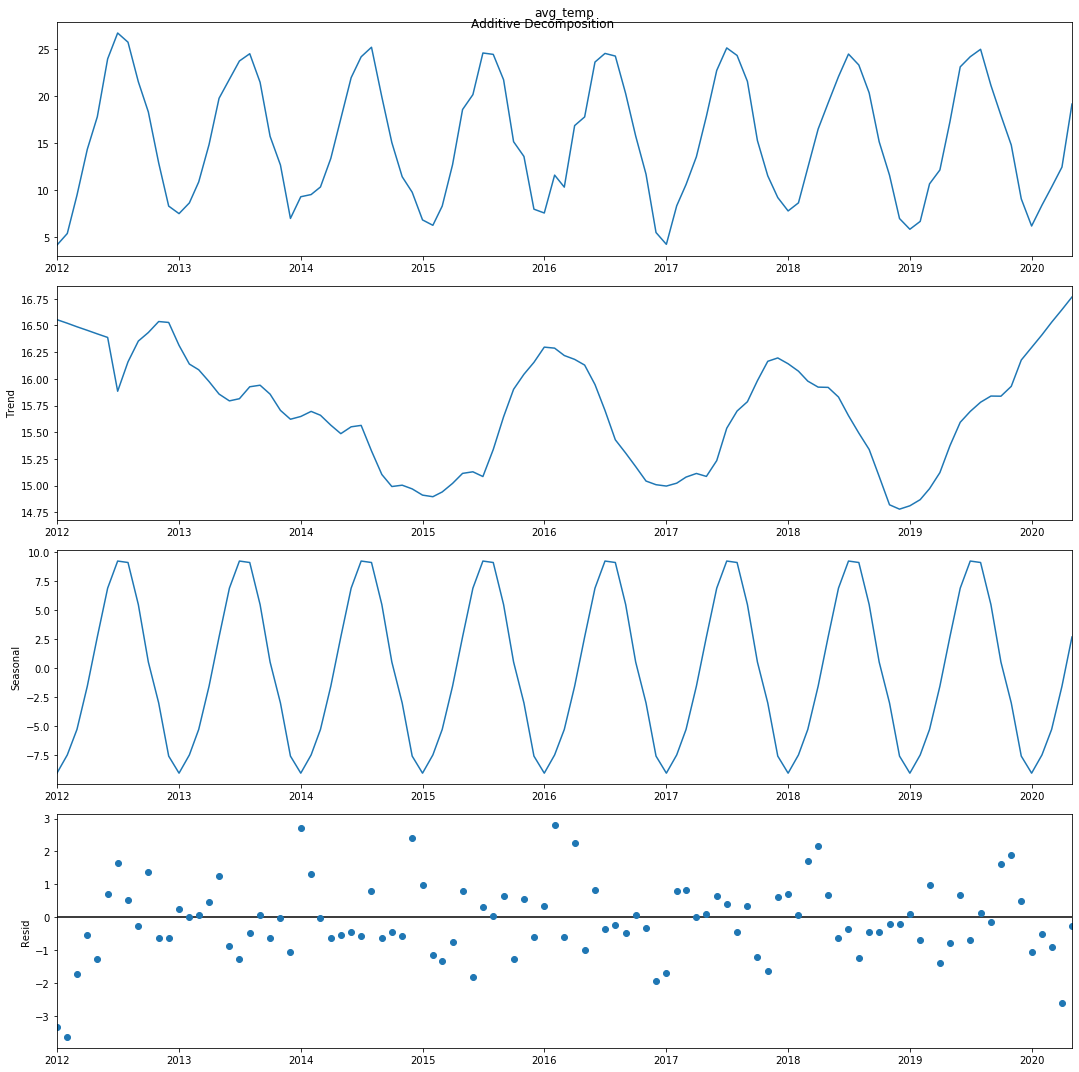

In [ ]:
#@title dataset decomposition
#data set decomposition
result_add = seasonal_decompose(dionisos_weather_df.dropna().avg_temp, model='additive', extrapolate_trend='freq',
                                period=12)
pyplot.rcParams.update({'figure.figsize': (15, 15)})
result_add.plot().suptitle('Additive Decomposition', fontsize=12)
pyplot.show()


# Finding the best values for AR and MA
## Correlation

Auto Correlation Function (ACF)<br>
We will use this to identify the best value for MA.

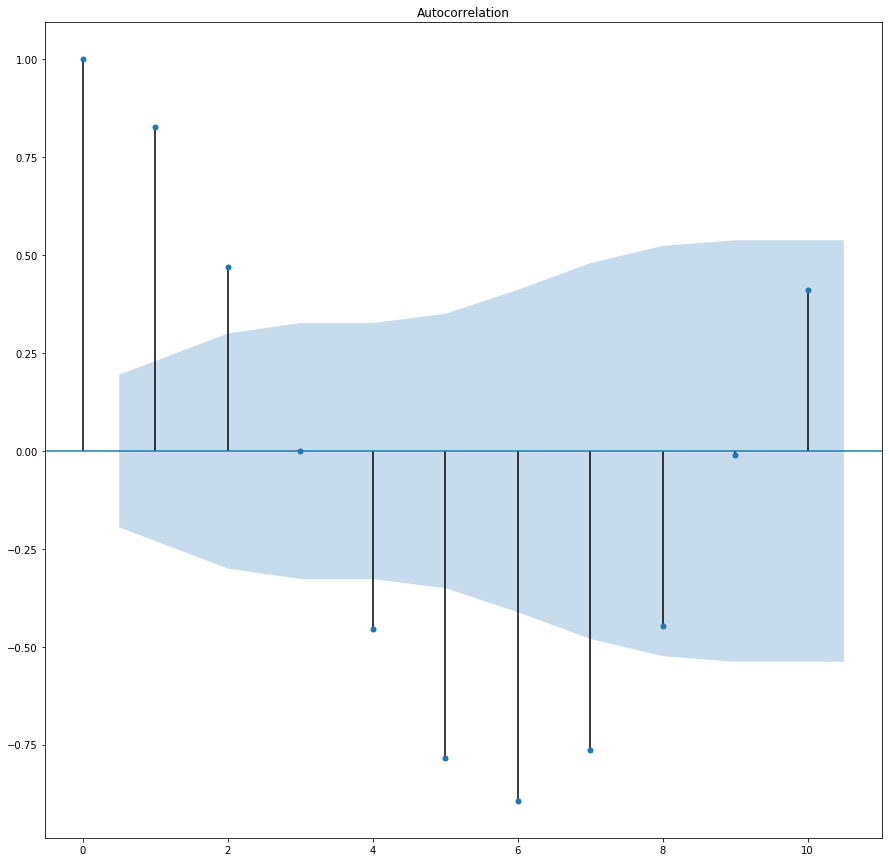

In [ ]:
plot_acf(dionisos_weather_df.dropna(), lags=10)
pyplot.show()

We can see that there is a strong positive correlation at 0 (which yields a value of 1 for MA)

## Partial Auto Correlation Function (PACF)
Use this to identify optimal value for AR

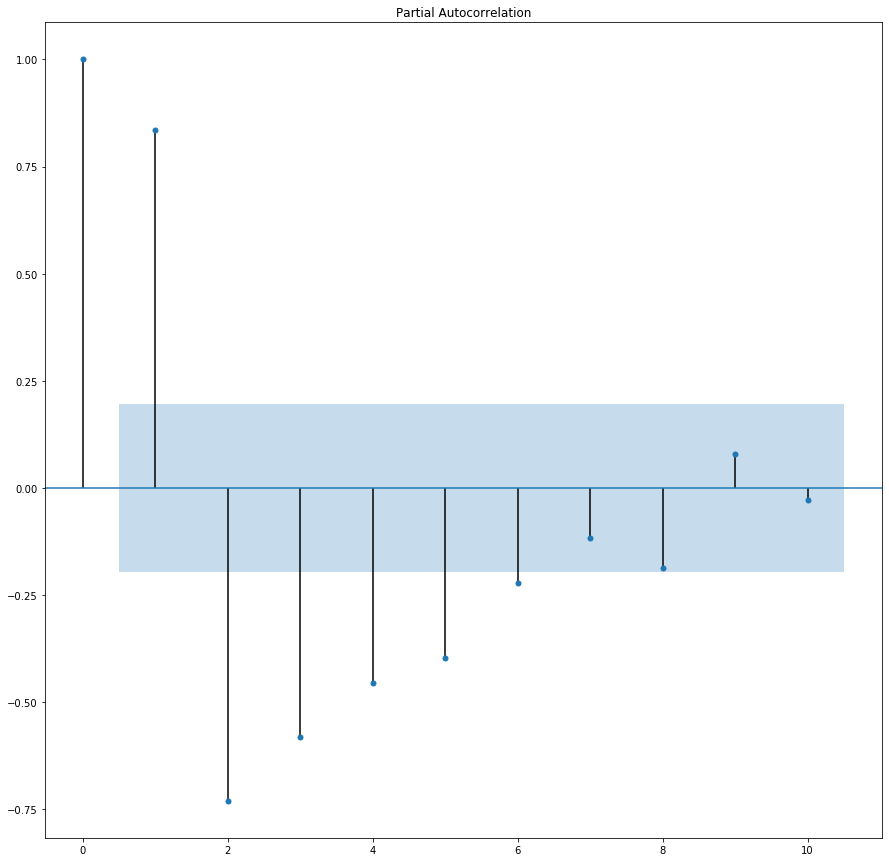

In [ ]:
plot_pacf(dionisos_weather_df.dropna(), lags=10)
pyplot.show()

We can see that there is a strong positive correlation at 0 (which yields a value of 1 for AR)

Based on the above findings a model of 1,0,1 (AR, Differencing, MA). 1's for AR and MA based on the PACF and ACF results, 0 for differencing as the data are already stationary.

## Tuning the model

Using the results of PACF and ACF, we will also perform a Grid Search in order to tune the model and find the best combination of parameters. We will try all p,d,q combinations of 0s and 1s for that purpose.

In [ ]:
#@title p,d,q
p = d = q = range(0,2)

# generate all diff combinations of p,q and d triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p,q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [ ]:
#@title Grid Search
# Grid Search

warnings.filterwarnings("ignore")
# parameter selection using grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dionisos_weather_df.dropna().avg_temp, order=param,
                                            seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('SARIMA{}x{}12-AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC:849.5599544101868
SARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC:669.2961901023205
SARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC:367.89426809128963
SARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC:272.0307871936817
SARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC:375.52845990510303
SARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC:322.7583619193231
SARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC:290.892466132462
SARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC:265.0630004419429
SARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC:718.7409479587016
SARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC:573.586926860026
SARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC:355.74957801188384
SARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC:263.3657892949476
SARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC:368.2651467740056
SARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC:310.4390341107716
SARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC:286.7682072397952
SARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC:260.2242921290565
SARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC:537.3377652312754
SARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC:433.5220123925018
SARIMA(0, 1, 0)x(0, 1, 0, 1

The best model (lowest AIC) is **SARIMA(0, 0, 1)x(1, 1, 1, 12)12**  (The Akaike Information Critera (AIC) is a widely used measure of a statistical model. ... When comparing two models, the one with the lower AIC is generally “better”).

We will apply these parameters to the model and plot diagnostics to visualize. 

In [ ]:
#@title best model fit
# best model (lowest AIC) is SARIMA(0, 0, 1)x(1, 1, 1, 12)12  (The Akaike Information Critera (AIC) is a widely used measure of a statistical model. ... When comparing two models, the one with the lower AIC is generally “better”)
mod = sm.tsa.statespace.SARIMAX(dionisos_weather_df,order = (0,0,1),seasonal_order =(1,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results=mod.fit()


## Plot Diagnostics

We need to ensure that: 

**Residuals of our model are uncorrelated and normally distributed with zero-mean**

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following: 

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.<br>
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.<br>
- The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.<br>


[reference](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)


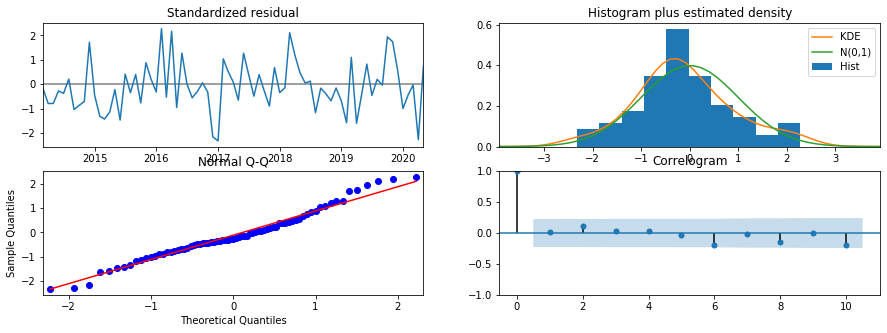

In [ ]:
#@title plot diagnostics
results.plot_diagnostics(figsize=(15, 5))
pyplot.show()


## Plot prediction

Next step is plotting the model's prediction vs the actual data set values.
More or less, the results are quite close to reality.

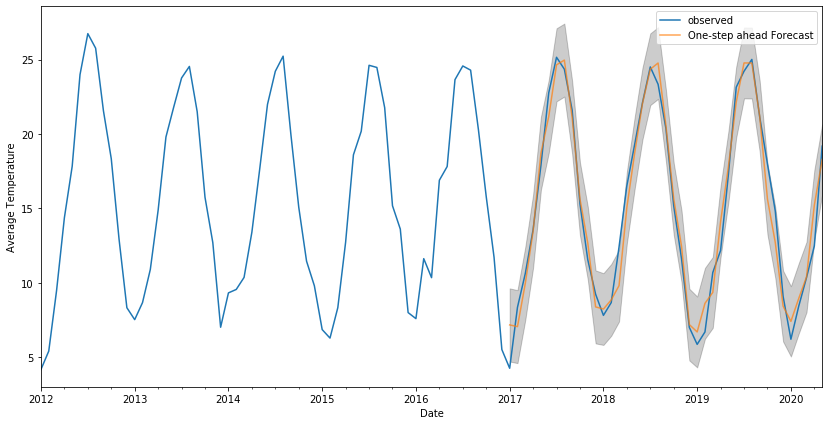

In [ ]:
#@title plot predicted values
# pred=results.get_prediction(start=pd.to_datetime('2012-01-02'),dynamic=False)
# removing the "start" parameter as it throws the following error "KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'"
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dionisos_weather_df.avg_temp.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature')
pyplot.legend()
pyplot.show()


## Forecast the future

Final step is to forecast how the future will look like....
We perform a forecast of 30 months ahead, on the average monthly temperature.

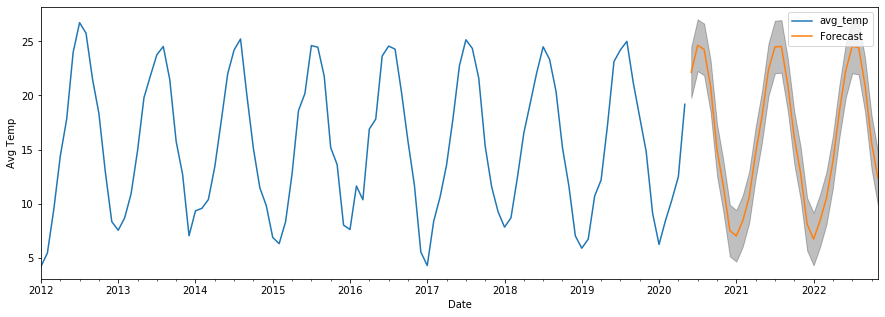

In [ ]:
#@title forecasting graph
# forecast, 30 months ahead
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = dionisos_weather_df.plot(label='observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Temp')
pyplot.legend()
pyplot.show()



In [ ]:
#@title forecasting actual values
x=pred_uc.predicted_mean.to_frame().join(pred_ci.iloc[0:])
x.rename(columns = {0:'avg_temp'}, inplace = True)
x.round({'avg_temp': 1, 'lower avg_temp': 1, 'upper avg_temp':1})

,avg_temp,lower avg_temp,upper avg_temp
2020-06-01,22.1,19.8,24.5
2020-07-01,24.7,22.3,27.0
2020-08-01,24.3,21.9,26.6
2020-09-01,20.9,18.5,23.3
2020-10-01,15.0,12.6,17.4
2020-11-01,11.6,9.2,14.0
2020-12-01,7.5,5.1,9.9
2021-01-01,7.0,4.6,9.4
2021-02-01,8.4,6.0,10.8
2021-03-01,10.6,8.2,13.0
